In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load the dataset
file_path = 'Ethereum Historical Data.csv'
df = pd.read_csv(file_path)
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)
df = df.sort_index()
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Price'] = df['Price'].interpolate(method='linear')

# Extract the 'Price' column
price_data = df['Price'].values.reshape(-1, 1)

# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

# Prepare the data
lookback = 60
X, y = [], []
for i in range(lookback, len(scaled_data)):
    X.append(scaled_data[i - lookback:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build the Optimized LSTM Model
model = Sequential([
    Input(shape=(lookback, 1)),
    LSTM(256, return_sequences=True),
    Dropout(0.2),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Train the model
model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Make predictions
predicted_prices = model.predict(X_test)
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))


Epoch 1/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 196ms/step - loss: 0.0466 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 2/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - loss: 0.0039 - val_loss: 3.0830e-04 - learning_rate: 0.0010
Epoch 3/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step - loss: 0.0026 - val_loss: 5.5510e-04 - learning_rate: 0.0010
Epoch 4/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.0025 - val_loss: 7.3166e-04 - learning_rate: 0.0010
Epoch 5/30
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - loss: 0.0024 - val_loss: 5.6183e-04 - learning_rate: 5.0000e-04
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step



Evaluation for 3-day Prediction:
RMSE: 227.30760693613317
MSE: 51668.74817103161
MAE: 220.99034505208328
MAPE: 8.448320858633117%
R²: -10.350393426603324

Evaluation for 7-day Prediction:
RMSE: 269.5387356276611
MSE: 72651.13000375817
MAE: 262.1126436941963
MAPE: 9.60538136044203%
R²: -5.358076052354007

Evaluation for 30-day Prediction:
RMSE: 332.4485646523385
MSE: 110522.0481394001
MAE: 316.03731998697924
MAPE: 9.633547171482741%
R²: 0.4180804956635418


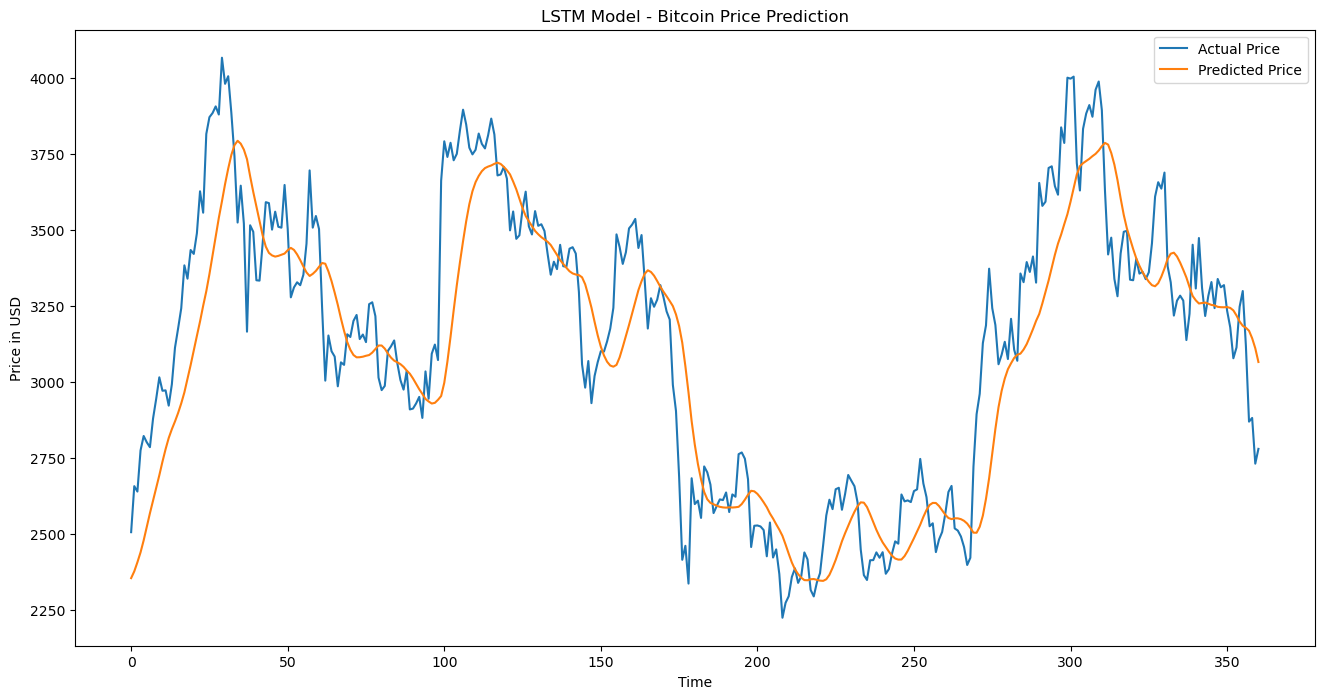

In [2]:
# Define function to evaluate metrics

def evaluate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100
    r2 = r2_score(y_true, y_pred)
    return rmse, mse, mae, mape, r2

# Evaluate metrics for 3-day, 7-day, and 30-day predictions
for days in [3, 7, 30]:
    metrics = evaluate_metrics(actual_prices[:days], predicted_prices[:days])
    print(f"\nEvaluation for {days}-day Prediction:")
    print(f"RMSE: {metrics[0]}")
    print(f"MSE: {metrics[1]}")
    print(f"MAE: {metrics[2]}")
    print(f"MAPE: {metrics[3]}%")
    print(f"R²: {metrics[4]}")

# Plot the results
plt.figure(figsize=(16, 8))
plt.plot(actual_prices, label='Actual Price')
plt.plot(predicted_prices, label='Predicted Price')
plt.title('LSTM Model - Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price in USD')
plt.legend()
plt.show()
